In [ ]:
using Pkg
Pkg.activate("../")

using StatsFuns
using Revise
using HiddenMarkovModel

In [ ]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)
sequence = ["a", "c", "b", "a"]
g1 = LinearGraph(sequence, emissionsmap)

In [ ]:
sequence = ["a", "d", "b", "a"]
g2 = LinearGraph(sequence, emissionsmap)

weightnormalize(g2)

In [ ]:
g3 = Graph()
s1 = addstate!(g3, State(1, 1, "hello"))
link!(initstate(g3), s1)
link!(s1, finalstate(g3))
# prevstate = initstate(g3)
# for (i, token) in enumerate(sequence)
#     s = addstate!(g3, State(i, emissionsmap[token], token))
#     link!(prevstate, s, 0.)
#     prevstate = s
# end
# link!(prevstate, finalstate(g3), 0.)
g3

In [ ]:
function union(g1::AbstractGraph, g2::AbstractGraph)
    g = Graph()
    statecount = 0
    old2new = Dict{AbstractState, AbstractState}(
        initstate(g1) => initstate(g),
        finalstate(g1) => finalstate(g),
    )
    for (i, state) in enumerate(states(g1))
        if id(state) ≠ finalstateid && id(state) ≠ initstateid
            statecount += 1
            old2new[state] = addstate!(g, State(statecount, pdfindex(state), name(state)))
        end
    end
    
    for state in states(g1)
        src = old2new[state]
        for link in children(state)
            link!(src, old2new[link.dest], link.weight)
        end
    end
    
    old2new = Dict{AbstractState, AbstractState}(
        initstate(g2) => initstate(g),
        finalstate(g2) => finalstate(g),
    )
    for (i, state) in enumerate(states(g2))
        if id(state) ≠ finalstateid && id(state) ≠ initstateid
            statecount += 1
            old2new[state] = addstate!(g, State(statecount, pdfindex(state), name(state)))
        end
    end
    
    for state in states(g2)
        src = old2new[state]
        for link in children(state)
            link!(src, old2new[link.dest], link.weight)
        end
    end
    
    g |> determinize |> weightnormalize
end
g = union(g1, g2)

In [ ]:
function leftminimize!(g::Graph, state::AbstractState)
    leaves = Dict() 
    for link in children(state)
        leaf, weight = get(leaves, pdfindex(link.dest), ([], -Inf))
        push!(leaf, link.dest)
        leaves[pdfindex(link.dest)] = (leaf, logaddexp(weight, link.weight))
    end
    
    empty!(state.outgoing)
    for (nextstates, weight) in values(leaves)
        mergedstate = nextstates[1]
        filter!(l -> l.dest ≠ state, mergedstate.incoming)

        # Now we removed all the extra states of the graph.
        links = vcat([next.outgoing for next in nextstates[2:end]]...)
        for link in links
            link!(mergedstate, link.dest, link.weight)
        end
        
        for old in nextstates[2:end]
            for link in children(old)
                filter!(l -> l.dest ≠ old, link.dest.incoming)
            end
            delete!(g.states, id(old))
        end
        
        # Reconnect the previous state with the merged state
        link!(state, mergedstate, weight)
        
        # Minimize the subgraph.
        leftminimize!(g, mergedstate)
    end
    g 
end


function rightminimize!(g::Graph, state::AbstractState)
    leaves = Dict() 
    for link in parents(state)
        leaf, weight = get(leaves, pdfindex(link.dest), ([], -Inf))
        push!(leaf, link.dest)
        leaves[pdfindex(link.dest)] = (leaf, logaddexp(weight, link.weight))
    end
    
    empty!(state.incoming)
    for (nextstates, weight) in values(leaves)
        mergedstate = nextstates[1]
        filter!(l -> l.dest ≠ state, mergedstate.outgoing)

        # Now we removed all the extra states of the graph.
        links = vcat([next.incoming for next in nextstates[2:end]]...)
        for link in links
            #link!(mergedstate, link.dest, link.weight)
            link!(link.dest, mergedstate, link.weight)
        end
        
        for old in nextstates[2:end]
            for link in parents(old)
                filter!(l -> l.dest ≠ old, link.dest.outgoing)
            end
            delete!(g.states, id(old))
        end
        
        # Reconnect the previous state with the merged state
        link!(mergedstate, state, weight)
        
        # Minimize the subgraph.
        rightminimize!(g, mergedstate)
    end
    g 
end
minimize(g::Graph) = begin
    newg = deepcopy(g)
    newg = leftminimize!(newg, initstate(newg)) 
    rightminimize!(newg, finalstate(newg)) 
end

In [ ]:
g

In [ ]:
g |> minimize

In [ ]:
g = g |> minimize |> determinize |> weightnormalize

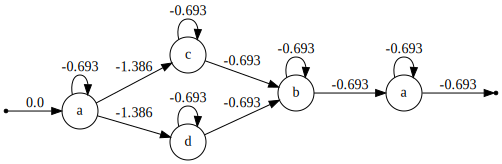

In [10]:
g = addselfloop(g) |> weightnormalize

In [ ]:
for (sid, state) in g.states
    println("state $(state) : $(state.incoming)")
    println("---")
end

In [24]:
S,N = 4,4
llh = randn(S, N)

4×4 Array{Float64,2}:
 0.969361  -0.356358   0.0693353  -0.100164
 1.90198    0.495418   1.81186     0.197264
 0.562628  -0.807082   1.05562     0.722059
 0.988841  -0.354341  -0.280863   -1.65567

In [30]:
α = αrecursion(g, llh; pruning=nopruning) # the lower the more pruning 
α

4-element Array{Dict{State,Float64},1}:
 Dict(State(id = 4, pdfindex = 1, a) => 0.9693610157675303)
 Dict(State(id = 4, pdfindex = 1, a) => -0.08014460853144317,State(id = 6, pdfindex = 4, d) => -0.7712741424333371,State(id = 2, pdfindex = 3, c) => -1.2240155385505405)
 Dict(State(id = 4, pdfindex = 1, a) => -0.7039564836230158,State(id = 6, pdfindex = 4, d) => -1.1836074593404295,State(id = 7, pdfindex = 2, b) => 2.258114863334863,State(id = 2, pdfindex = 3, c) => 0.8450680115049921)
 Dict(State(id = 4, pdfindex = 1, a) => -1.497267542619595,State(id = 6, pdfindex = 4, d) => -3.388970260356466,State(id = 5, pdfindex = 1, a) => 1.4648038043382838,State(id = 7, pdfindex = 2, b) => 2.1736502845674788,State(id = 2, pdfindex = 3, c) => 1.0717538672092162)

In [31]:
β = βrecursion(g, llh; pruning=nopruning) # the lower the more pruning 
β

4-element Array{Dict{State,Float64},1}:
 Dict(State(id = 4, pdfindex = 1, a) => -1.6162019594339492,State(id = 6, pdfindex = 4, d) => -0.0938534122913855,State(id = 5, pdfindex = 1, a) => -3.15977573894707,State(id = 7, pdfindex = 2, b) => -0.3425135868737629,State(id = 2, pdfindex = 3, c) => -0.19603467081876866)
 Dict(State(id = 6, pdfindex = 4, d) => -0.3677492483667335,State(id = 5, pdfindex = 1, a) => -2.1102701146480967,State(id = 7, pdfindex = 2, b) => -0.2064142992702488,State(id = 2, pdfindex = 3, c) => -0.3677492483667335)
 Dict(State(id = 5, pdfindex = 1, a) => -1.4864582395565245,State(id = 7, pdfindex = 2, b) => -1.4864582395565245)
 Dict(State(id = 5, pdfindex = 1, a) => -0.6931471805599453)

In [56]:
T = eltype(llh)
γ = Matrix{T}(undef, size(llh))
fill!(γ, T(-Inf))
# a = Matrix{T}(undef, size(llh))
# fill!(a, T(-Inf))
# b = Matrix{T}(undef, size(llh))
# fill!(b, T(-Inf))

for n in 1:size(llh, 2)
    for (s1, w1) in α[n]
        for (s2, w2) in β[n]
            if s1.pdfindex == s2.pdfindex
                γ[s1.pdfindex, n] = logaddexp(γ[s1.pdfindex, n], w1 + w2)
            end
        end
    end
end       
#     for (s, w) in α[n]
#         a[s.pdfindex, n] = logaddexp(a[s.pdfindex, n], w)
#     end
#     for (s, w) in β[n]
#         b[s.pdfindex, n] = logaddexp(b[s.pdfindex, n], w)
#     end
# end
# γ = a + b .- logsumexp(a + b, dims = 1)
γ

4×4 Array{Float64,2}:
  2.14527    1.13887    0.250768   1.32846
 -0.342514   0.892198   2.51825    2.17365
 -0.196035   0.904335   1.53822    1.07175
 -0.0938534  1.12881   -0.49046   -3.38897

In [54]:
T = eltype(llh)
γ = Matrix{T}(undef, size(llh))
fill!(γ, T(-Inf))
a = Matrix{T}(undef, 5, 4)
fill!(a, T(-Inf))
b = Matrix{T}(undef, 5, 4)
fill!(b, T(-Inf))

map = Dict(4 => 1, 2 => 2, 6 => 3, 7 => 4, 5 => 5)

for n in 1:size(llh, 2)
    for (s, w) in α[n]
        a[map[id(s)], n] = logaddexp(a[map[id(s)], n], w)
    end
    for (s, w) in β[n]
        b[map[id(s)], n] = logaddexp(b[map[id(s)], n], w)
    end
end
display(a)
display(b)
γ = a + b .- logsumexp(a + b, dims = 1)

# for (id, s) in g.states
#     println(s, s.name, id)
# end

5×4 Array{Float64,2}:
   0.969361   -0.0801446   -0.703956  -1.49727
 -Inf         -1.22402      0.845068   1.07175
 -Inf         -0.771274    -1.18361   -3.38897
 -Inf        -Inf           2.25811    2.17365
 -Inf        -Inf         -Inf         1.4648

5×4 Array{Float64,2}:
 -1.6162     -Inf        -Inf       -Inf
 -0.196035    -0.367749  -Inf       -Inf
 -0.0938534   -0.367749  -Inf       -Inf
 -0.342514    -0.206414   -1.48646  -Inf
 -3.15978     -2.11027    -1.48646   -0.693147

5×4 Array{Float64,2}:
   0.0  -Inf        -Inf   -Inf
 -Inf    -0.944924  -Inf   -Inf
 -Inf    -0.492182  -Inf   -Inf
 -Inf   -Inf          0.0  -Inf
 -Inf   -Inf        -Inf     0.0

In [48]:
display(g.states[4])
display(g.states[5])
g.states[4] == g.states[5]


State(id = 4, pdfindex = 1, a)

State(id = 5, pdfindex = 1, a)

false

In [38]:
T = eltype(llh)
γ = Matrix{T}(undef, size(llh))
fill!(γ, T(-Inf))
a = Matrix{T}(undef, 10, 4)
fill!(a, T(-Inf))
b = Matrix{T}(undef, 10, 4)
fill!(b, T(-Inf))

for n in 1:size(llh, 2)
    for (s, w) in α[n]
        a[id(s), n] = logaddexp(a[id(s), n], w)
    end
    for (s, w) in β[n]
        b[id(s), n] = logaddexp(b[id(s), n], w)
    end
end
γ = a + b .- logsumexp(a + b, dims = 1)

10×4 Array{Float64,2}:
 -Inf   -Inf        -Inf   -Inf
 -Inf    -0.944924  -Inf   -Inf
 -Inf   -Inf        -Inf   -Inf
   0.0  -Inf        -Inf   -Inf
 -Inf   -Inf        -Inf     0.0
 -Inf    -0.492182  -Inf   -Inf
 -Inf   -Inf          0.0  -Inf
 -Inf   -Inf        -Inf   -Inf
 -Inf   -Inf        -Inf   -Inf
 -Inf   -Inf        -Inf   -Inf

4×4 Array{Float64,2}:
   0.969361   -0.0801446  -0.703956   1.51522
 -Inf        -Inf          2.25811    2.17365
 -Inf         -1.22402     0.845068   1.07175
 -Inf         -0.771274   -1.18361   -3.38897

In [113]:
α[2]

Dict{State,Float64} with 1 entry:
  State(id = 8, pdfindex = 1, a) => -1.2072

search: filter! filter fieldtype fieldtypes finalstate finalstateid



```
filter!(f, a::AbstractVector)
```

Update `a`, removing elements for which `f` is `false`. The function `f` is passed one argument.

# Examples

```jldoctest
julia> filter!(isodd, Vector(1:10))
5-element Array{Int64,1}:
 1
 3
 5
 7
 9
```

---

```
filter!(f, d::AbstractDict)
```

Update `d`, removing elements for which `f` is `false`. The function `f` is passed `key=>value` pairs.

# Example

```jldoctest
julia> d = Dict(1=>"a", 2=>"b", 3=>"c")
Dict{Int64,String} with 3 entries:
  2 => "b"
  3 => "c"
  1 => "a"

julia> filter!(p->isodd(p.first), d)
Dict{Int64,String} with 2 entries:
  3 => "c"
  1 => "a"
```


In [83]:
lnαβ = αβrecursion(g, llh) # the lower the more pruning 
exp.(lnαβ)

4×4 Array{Float64,2}:
 1.0  0.945357   0.948721   1.0
 0.0  0.0        0.0512785  0.0
 0.0  0.0339451  0.0        0.0
 0.0  0.0206974  0.0        0.0

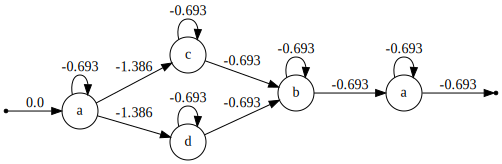

In [84]:
g

State[State(id = 5, pdfindex = 1, a)]
[-0.8551561887348482]
-----
State[State(id = 7, pdfindex = 2, b), State(id = 5, pdfindex = 1, a)]
[-1.2488083877617786, -1.9778213566053067]
-----
State[State(id = 7, pdfindex = 2, b), State(id = 6, pdfindex = 4, d), State(id = 2, pdfindex = 3, c)]
[-Inf, -3.8706317322238837, -1.383485432899563]
-----
State[State(id = 2, pdfindex = 3, c), State(id = 4, pdfindex = 1, a)]
[-Inf, -1.3834854328995632]
-----


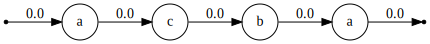

In [29]:
path = viterbi(g, llh)

In [30]:
g.states

Dict{Union{Missing, HiddenMarkovModel.FinalStateID, HiddenMarkovModel.InitStateID, Int64},State} with 7 entries:
  7            => State(id = 7, pdfindex = 2, b)
  4            => State(id = 4, pdfindex = 1, a)
  finalstateid => State(id = finalstateid, pdfindex = nothing, finalstateid)
  initstateid  => State(id = initstateid, pdfindex = nothing, initstateid)
  2            => State(id = 2, pdfindex = 3, c)
  5            => State(id = 5, pdfindex = 1, a)
  6            => State(id = 6, pdfindex = 4, d)

In [31]:
lnαβ = αβrecursion(g, llh, pruning = 2.1) # the lower the more pruning 
exp.(lnαβ)

4×4 Array{Float64,2}:
 1.0  0.337556  0.355641  1.0
 0.0  0.0       0.644359  0.0
 0.0  0.611592  0.0       0.0
 0.0  0.050852  0.0       0.0

In [32]:
v = [(1, 3), (2, 2), (3, 1)]
findmax(v)

((3, 1), 3)